In [1]:
import numpy as np
import b18_routines as b18
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
verbose = 1

# Badro et al 2016, Figure 1b

The equations are 

$$ log K_{Mg} = 1.23 - \frac{18816}{T} $$ 
$$ K_{Mg} = \frac{X_{Mg}^2}{X_{MgO}}$$

Hence

$$ 2 log X_{mg} = 1.23 + log X_{MgO} - \frac{18816}{T} $$

Since $X_{MgO} = 0.5$, $log X_{MgO} = -0.3$ we have

$$ X_{mg} = 10^{0.46 - 9408/T} .$$

The cell below reproduces Fig 1b. 


# Fischer

Gives us Kd for O and Si. These agree with their Fig 6. Note that to see the agreement for O requires evaluating ay 100GPa rather than 135 GPa. 

In [3]:
def Mg_exchange(XMgO, XFe, XFeO, KMg, loggammaO, loggammaMg):
    """B18 eqn 10"""
    return 10**( np.log10(KMg) + np.log10(XFe*XMgO) - np.log10(XFeO) - loggammaO - loggammaMg)

def Mg_dissolution(XMgO, KMg, loggammaO, loggammaMg):
    """B18 eqn 9"""
    return 10**( np.log10(KMg) + np.log10(XMgO) - loggammaO - loggammaMg)

def Mg_dissolution_B16(XMgO,KMg):
    return 10**( (np.log10(KMg) + np.log10(XMgO))/2.0 )

def Mg_dissociation(XMgO, XO, KMg, loggammaO, loggammaMg):
    """B18 eqn 8"""
    return 10**( np.log(XMgO) + np.log(KMg) - np.log(XO) - loggammaO - loggammaMg)

In [4]:
# Set up input parameters that will be fixed throughout
a, b, c = 0.1  ,-14054, 0.0 # Dissociation
a, b, c = -1.98, -4402, 0.0 # Exchange

a_Mg_B16, b_Mg_B16, c_Mg_B16 = 1.23, -18816.0, 0.0
a_Mg_B18, b_Mg_B18, c_Mg_B18 = 1.06  ,-12842, 0.0 # Dissolution - use this for now. 

a_Mg_OS, b_Mg_OS, c_Mg_OS = 0.1,-10851,0.0
a_Si_OS, b_Si_OS, c_Si_OS = 1.3,-13500,0.0  # Fischer
a_O_OS , b_O_OS , c_O_OS  = 0.6,-3800 ,22.0 # Fischer 2015

# From the paper
eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0,-17.1, 3.6, 9.0, 4.9

# From JBs spreadsheet
eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0, -7.4, 9.7, 9.0, 6.1
eps_CMg, eps_OMg , eps_SiMg, eps_SMg                = 0.0, -21.6, 4.6, 0.0

In [5]:
# These params may want to change...
Tcmb   = np.linspace(6000,2000,101)

XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(0.03, 0.03, 0.0) 
print(XO_c, XSi_c, XMgO_c)
XS_c = 0.0000
XC_c = 0.0000
XFe_c= 1-XO_c-XSi_c-XMgO_c
XMgO_m = 0.5

0.09502262443438914 0.05429864253393665 0.0


In [21]:
cO_c_ni, cSi_c_ni, cMg_c_ni = np.zeros(len(Tcmb)), np.zeros(len(Tcmb)), np.zeros(len(Tcmb))
loggammaO, loggammaMg       = np.zeros(len(Tcmb)), np.zeros(len(Tcmb))

# eps needs to be a YxY symmetric matrix containing coeffs for C, O, Si, S, Mg, ...,. 
X_C   = np.array( [XC_c   , XO_c   , XSi_c   , XS_c   , XMgO_c])
eps_C = np.array([[eps_CC , eps_OC , eps_CSi , eps_SC , eps_CMg], 
                  [eps_OC , eps_OO , eps_OSi , eps_OS , eps_OMg], 
                  [eps_CSi, eps_OSi, eps_SiSi, eps_SSi, eps_SiMg],
                  [eps_SC , eps_OS , eps_SSi , eps_SS , eps_SMg],
                  [eps_CMg, eps_OMg, eps_SiMg, eps_SMg, eps_MgMg]])

print('Input mole fractions [C, O, Si, S]: \n', X_C)
print('Input eps matrix: \n', eps_C)

lngamma0a = [-0.62,     4.29, -6.65, 0.0, 0.0]
lngamma0b = [-0.00, -16500.0, 0.00 , 0.0, 0.0]

T0 = 1873.0
verb = 0

tt = 0
for t in Tcmb: 
    eps = eps_C * T0 / t                                             # eqn S6
    lngamma0   = lngamma0a + lngamma0b/t
    lngamma0   = lngamma0  * (T0 / t)                                # eqn S5
    lngamma0[1]= lngamma0[1] * t/T0                                  # Do not set 
    lngammaFe  = b18.ln_gamma_Fe(X_C,eps,verb)                       # eqn S3
    lngammai   = b18.ln_gamma_i( X_C,eps, lngammaFe, lngamma0, verb) # eqn S4
        
    if verbose == 1:
        print('T = {:6.1f} gammaC0 = {:6.4f} gamma_O0 = {:6.4f} gammaSi0 = {:6.4f} gammaS0 = {:6.4f} gammaMg0 = {:6.4f}'
              .format(t,np.exp(lngamma0[0]),np.exp(lngamma0[1]),np.exp(lngamma0[2]), np.exp(lngamma0[3]), np.exp(lngamma0[4])))
        print('T = {:6.1f} gammaC  = {:6.4f} gamma_O  = {:6.4f} gammaSi  = {:6.4f} gammaS  = {:6.4f} gammaMg  = {:6.4f} gammaFe  = {:5.3f}'
          .format(t,np.exp(lngammai[0]),np.exp(lngammai[1]),np.exp(lngammai[2]), np.exp(lngammai[3]),np.exp(lngammai[4]), np.exp(lngammaFe)))

    loggammaO[tt]  = lngammai[1]/2.303
    loggammaMg[tt] = lngammai[4]/2.303
        
    tt = tt + 1

Input mole fractions [C, O, Si, S]: 
 [0.         0.09502262 0.05429864 0.         0.        ]
Input eps matrix: 
 [[ 12.8 -20.    9.7   6.1   0. ]
 [-20.   -1.   -5.   -7.4 -21.6]
 [  9.7  -5.   12.4   9.    4.6]
 [  6.1  -7.4   9.   -5.7   0. ]
 [  0.  -21.6   4.6   0.    0. ]]
T = 6000.0 gammaC0 = 0.8240 gamma_O0 = 4.6646 gammaSi0 = 0.1254 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 6000.0 gammaC  = 0.8282 gamma_O  = 4.1259 gammaSi  = 0.1326 gammaS  = 1.0050 gammaMg  = 1.0050 gammaFe  = 1.005
T = 5960.0 gammaC0 = 0.8230 gamma_O0 = 4.5793 gammaSi0 = 0.1237 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 5960.0 gammaC  = 0.8271 gamma_O  = 4.0471 gammaSi  = 0.1309 gammaS  = 1.0051 gammaMg  = 1.0051 gammaFe  = 1.005
T = 5920.0 gammaC0 = 0.8219 gamma_O0 = 4.4944 gammaSi0 = 0.1220 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 5920.0 gammaC  = 0.8261 gamma_O  = 3.9688 gammaSi  = 0.1291 gammaS  = 1.0051 gammaMg  = 1.0051 gammaFe  = 1.005
T = 5880.0 gammaC0 = 0.8208 gamma_O0 = 4.4100 gammaSi0 = 0.1202 gammaS0 = 

In [22]:
# Compare logKd values form different studies
logKd_MgO_B16 = b18.logKd_ideal(a_Mg_B16, b_Mg_B16, c_Mg_B16, Tcmb)
logKd_MgO_B18 = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb)
logKd_MgO_O16 = b18.logKd_ideal(a_Mg_OS , b_Mg_OS , c_Mg_OS , Tcmb)

logKd_O       = b18.logKd_ideal(a_O_OS , b_O_OS , c_O_OS , Tcmb) #From Fischer and used in Mittal & O16
logKd_Si      = b18.logKd_ideal(a_Si_OS, b_Si_OS, c_Si_OS, Tcmb) #From Fischer and used in Mittal & O16

Kd_O  = 10**logKd_O #From Fischer and used in Mittal
Kd_Si = 10**logKd_Si
Kd_Mg = 10**logKd_MgO_O16

XFeO_m  = 10**( np.log10(XFe_c*XO_c)   - logKd_O )
XSiO2_m = 10**( np.log10(XSi_c*XFeO_m) - np.log10(XFe_c) - logKd_Si )

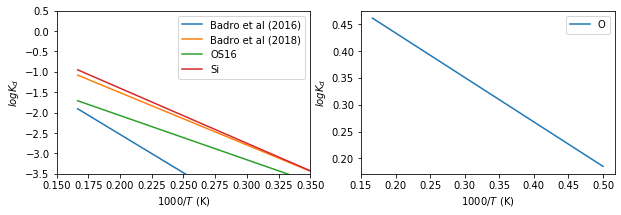

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,3))

ax1.set_ylim([-3.5,0.5]) # Fischer Fig 6
ax1.set_xlabel("$1000/T$ (K)")
ax1.set_ylabel("$log K_d$")
ax1.set_xlim([0.15,0.35])
ax1.plot(1000.0/Tcmb, logKd_MgO_B16, label="Badro et al (2016)")
ax1.plot(1000.0/Tcmb, logKd_MgO_B18, label="Badro et al (2018)")
ax1.plot(1000.0/Tcmb, logKd_MgO_O16, label="OS16")
ax1.plot(1000.0/Tcmb, logKd_Si, label="Si")
ax1.legend()

#ax2.set_ylim([-5,2]) # Fischer Fig 6
ax2.set_xlabel("$1000/T$ (K)")
ax2.set_ylabel("$log K_d$")
ax2.plot(1000.0/Tcmb, logKd_O, label="O")
ax2.legend()

In [30]:
# Find the eq conc at each T for just MgO equilibrium
XMg_B16_E  = Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_B16, 0.0, 0.0)
XMg_B18_E  = Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_B18, 0.0, 0.0)
XMg_O16_E  = Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_O16, 0.0, 0.0)
cO_c_B16_E, cSi_c_B16_E, cMg_c_B16_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_E)
cO_c_B18_E, cSi_c_B18_E, cMg_c_B18_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_B18_E)
cO_c_O16_E, cSi_c_O16_E, cMg_c_O16_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_E)

XMg_B16_DC = Mg_dissociation(XMgO_m, XO_c, 10**logKd_MgO_B16 , 0.0, 0.0)
XMg_B18_DC = Mg_dissociation(XMgO_m, XO_c, 10**logKd_MgO_B18 , 0.0, 0.0)
XMg_O16_DC = Mg_dissociation(XMgO_m, XO_c, 10**logKd_MgO_O16, 0.0, 0.0)

XMg_B16_DL = Mg_dissolution(XMgO_m, 10**logKd_MgO_B16, 0.0, 0.0)
XMg_B18_DL = Mg_dissolution(XMgO_m, 10**logKd_MgO_B18, 0.0, 0.0)
XMg_O16_DL = Mg_dissolution(XMgO_m, 10**logKd_MgO_O16, 0.0, 0.0)
cO_c_B16_DL, cSi_c_B16_DL, cMg_c_B16_DL = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_DL)
cO_c_B18_DL, cSi_c_B18_DL, cMg_c_B18_DL = b18.mole2massconc_core(XO_c, XSi_c, XMg_B18_DL)
cO_c_O16_DL, cSi_c_O16_DL, cMg_c_O16_DL = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_DL)

print('Tcmb        = ', Tcmb[0])
print('Input mole fractions [C, O, Si, S, Mg]: \n', X_C)
print('XMgO_mantle = ', XMgO_m)
print('a + b/T     = ', logKd_MgO_B18[0])
print('log_gammaO  = ', loggammaO[0])
print('log_gammaMg = ', loggammaMg[0])
print('XMgO_core   = ', XMg_B18_DLni[0])
print(10**(a_Mg_B18 + b_Mg_B18/Tcmb[0] + np.log10(XMgO_m) - loggammaO[0] - loggammaMg[0]))

XMg_B18_DLni  = Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,loggammaMg)
XO_c_ni       = XMg_B18_DLni + XO_c                                         # Add O in MgO to core O 
cO_c_B18_DLni, cSi_c_B18_DLni, cMg_c_B18_DLni = b18.mole2massconc_core(XO_c_ni, XSi_c, XMg_B18_DLni)

XMg_B18_DLni2 = Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,0.0)
XO_c_ni      =  XMg_B18_DLni2 + XO_c                                         # Add O in MgO to core O 
cO_c_B18_DLni2, cSi_c_B18_DLni2, cMg_c_B18_DLni2 = b18.mole2massconc_core(XO_c_ni, XSi_c, XMg_B18_DLni2)

# Making sure we can reproduce B16 Fig 1b
XMg_B16_3 = Mg_dissolution_B16(XMgO_m, 10**logKd_MgO_B16)
cO_c_B16_3, cSi_c_B16_3, cMg_c_B16_3 = b18.mole2massconc_core(0.0, 0.0, XMg_B16_3)

Tcmb        =  6000.0
Input mole fractions [C, O, Si, S, Mg]: 
 [0.         0.09502262 0.05429864 0.         0.        ]
XMgO_mantle =  0.5
a + b/T     =  -1.0803333333333334
log_gammaO  =  0.6154065827354627
log_gammaMg =  0.0021802825156432334
XMgO_core   =  0.010024201910196914
0.010024201910196914


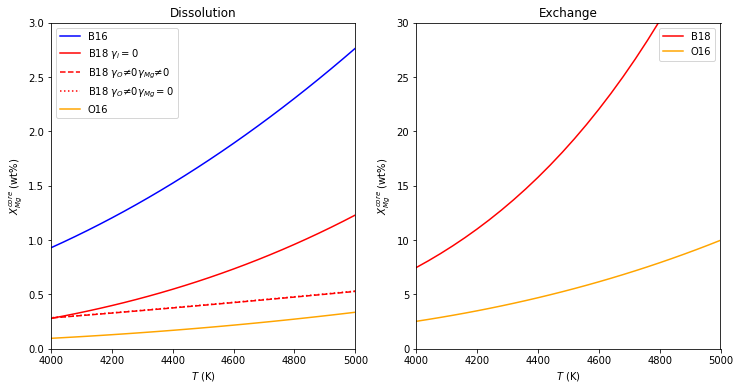

In [25]:
fig, (ax2,ax3) = plt.subplots(1,2,figsize=(12,6))

ax2.set_title("Dissolution")
ax2.set_xlim([4000,5000])
ax2.set_ylim([0   ,3   ])
ax2.set_xlabel("$T$ (K)")
ax2.set_ylabel("$X_{Mg}^{core}$ (wt%)")
ax2.plot(Tcmb, cMg_c_B16_3*100    , label='B16', color="blue")
#ax2.plot(Tcmb, cMg_c_B16_DL*100   , label="B16" , color="blue")
ax2.plot(Tcmb, cMg_c_B18_DL*100   , label="B18 $\gamma_i=0$"         , color='red')
ax2.plot(Tcmb, cMg_c_B18_DLni*100 , label="B18 $\gamma_O\\ne0 \gamma_{Mg}\\ne0$ ", color='red',linestyle='--')
ax2.plot(Tcmb, cMg_c_B18_DLni2*100, label="B18 $\gamma_O\\ne0 \gamma_{Mg}=0$ " , color='red',linestyle=':')
ax2.plot(Tcmb, cMg_c_O16_DL*100   , label="O16", color='orange')
ax2.legend()

ax3.set_title("Exchange")
ax3.set_xlim([4000,5000])
ax3.set_ylim([0   ,30   ])
ax3.set_xlabel("$T$ (K)")
ax3.set_ylabel("$X_{Mg}^{core}$ (wt%)")
#ax3.plot(Tcmb, cMg_c_B16_E*100 , label="B16" , color="blue")
ax3.plot(Tcmb, cMg_c_B18_E*100 , label="B18" , color="red")
ax3.plot(Tcmb, cMg_c_O16_E*100, label="O16", color="orange")
ax3.legend()

## Badro et al (2018) SI 

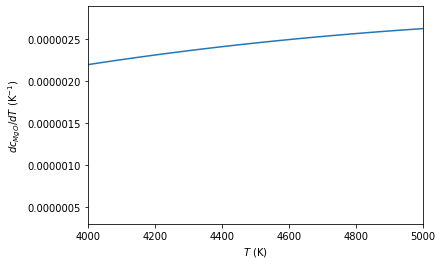

In [11]:
dT = Tcmb[1] - Tcmb[0]
dcMgdT = np.gradient(cMg_c_B18_DLni, dT)
plt.xlim([4000,5000])
plt.xlabel("$T$ (K)")
plt.ylabel("$dc_{MgO}/dT$ (K$^{-1}$)")
plt.plot(Tcmb, dcMgdT)